In [1]:
import shutil
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import os
import tkinter as tk
from tkinter import filedialog
from tkinter import simpledialog
from tkinter import ttk

In [2]:
tk.Tk().withdraw() # prevents an empty tkinter window from appearing
root_access = 'BCS 915_172.16.148.45/Process-Export'

#Select only your main test folder, ex: 
Test_path = Path(filedialog.askdirectory(initialdir = root_access))

# Automaticaly select the folder that contains the data for cycles at 1C
Data_path = Path(os.path.join(Test_path, '1C_rate_Cycles'))
print(Data_path)    # Show the path

# Define the folder to save the graphs into, as .png files
Output_path = Path(os.path.join(Test_path, 'Graphs_Output'))

# Create the list that will contain all the test files
file_list = [file for file in Data_path.iterdir() if file.is_file()]
df_list = []
# Show the files contained in the list
for file in file_list: 
    print(Path(file).stem)

C:\Users\mmeyer\OneDrive - FIB Srl\Documents\Python\TEV1_Cell Testing\BCS 915_172.16.148.45\Process-Export\20250121_TEV1_STD_CLT\1C_rate_Cycles
1C_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_A.1
1C_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_A.5
1C_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_B.1
1C_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_B.5
1C_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_C.1
1C_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_C.5
1C_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_D.1
1C_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_D.5


In [3]:
def extract_values_on_discharge(df_list):
    # List to store discharge data
    discharge_results = []

    # Initialise the last value for 'Task' and 'Q discharge /Ah' columns
    last_dch_step = None
    last_dch_values = []  # Create an empty list to store values
    iteration_counter = 0  # iteration counter

    # Parcourir le DataFrame
    for index, row in df_list.iterrows():
        current_dch_value = row['Q discharge /Ah']
        current_dch_step = row['Task']

        # Check if 'Task' value is different
        if current_dch_step != last_dch_step:
            # If it is not the first line, add the last value found in results
            if last_dch_step is not None:
                Qmax = np.max(last_dch_values) if last_dch_values else None  # Calculate maximum value of previous values
                
                # Save the results only if last step value was 'CC'
                if last_dch_step == 'CC':
                    discharge_results.append((iteration_counter, Qmax))  # Save counter and Qmax value

                    iteration_counter += 1
            
            # Update last_step and last_values for current values
            last_dch_step = current_dch_step
            last_dch_values = [current_dch_value]  # Reset for current value

        else:
            last_dch_values.append(current_dch_value)  # Add values to the list if 'Task' is the same

    # Add last value when ending the iteration
    if last_dch_step is not None and last_dch_values:
        Qmax = np.max(last_dch_values)
        
        # Save data only if last step was 'CC'
        if last_dch_step == 'CC':
            discharge_results.append((iteration_counter, Qmax))  # Save last counter and Qmax value

    return discharge_results

all_discharges = []  # List to store all files results
discharges = []

for file in file_list:
    try:
        df_list = pd.read_csv(file, low_memory=False)

        # Filter dataframe to exclude specific tasks and steps
        #df_filter = df_list[(df_list['Task'] != 'AUP') & 
        #                    (df_list['Step'] != 'task_4') &
        #                    (df_list['Step'] != 'task_2') &
        #                    (df_list['Step'] != 'task_8') &
        #                    (df_list['Step'] != 'task_12')]

        # Check if dataframe is not empty
        #if df_filter.empty:
        if df_list.empty:
            print(f"Aucun enregistrement trouvé après filtrage dans le fichier {file}.")
            continue
        
        # Apply the function extract_values_on_discharge on dataframe df_list
        discharges = extract_values_on_discharge(df_list)
        
        # Check if modifications have been detected
        if discharges:
            # Add results to all_discharges with file name
            all_discharges.append((file, discharges))
        else:
            print(f"Aucun changement détecté dans le fichier {file}.")

    except Exception as e:
        print(f"Erreur lors du traitement du fichier {file}: {e}")

In [ ]:
def extract_values_on_charge(df_list):
    charge_results = []

    # Initialise the last value for 'Task' and 'Capacity /Ah' columns
    last_ch_step = None
    last_ch_values = []  # Create an empty list to store values
    charge_counter = 0  # Compteur d'itération

    for index, row in df_list.iterrows():
        current_ch_value = row['Capacity /Ah']
        current_ch_step = row['Task']

        # Check if 'Task' has changed
        if current_ch_step != last_ch_step:
            # If it is not the first line, add the last value found in results
            if last_ch_step is not None:
                Qchar = np.max(last_ch_values) if last_ch_values else None 
                
                # Save only if last step value was 'CC_CV'
                if last_ch_step == 'CC_CV':
                    charge_results.append((charge_counter, Qchar))

                    charge_counter += 1
            
            # Update last_step and last_values with current values
            last_ch_step = current_ch_step
            last_ch_values = [current_ch_value]  # Reset with current value

        else:
            last_ch_values.append(current_ch_value) 

    # Add the last value at the end of iteration
    if last_ch_step is not None and last_ch_values:
        Qchar = np.max(last_ch_values)
        
        # Save only if the last step was 'CC_CV'
        if last_ch_step == 'CC_CV':
            charge_results.append((charge_counter, Qchar)) 

    return charge_results

all_charges = []  # List to store all files results
charges = []

for file in file_list:
    try:
        df_list = pd.read_csv(file, low_memory=False)

        # Filter dataframe to exclude specific tasks and steps
        #df_filter = df_list[(df_list['Task'] != 'AUP') & 
        #                    (df_list['Step'] != 'task_4') &
        #                    (df_list['Step'] != 'task_2') &
        #                    (df_list['Step'] != 'task_8') &
        #                    (df_list['Step'] != 'task_12')]

        # Check if dataframe is not empty
        #if df_filter.empty:
        if df_list.empty:
            print(f"Aucun enregistrement trouvé après filtrage dans le fichier {file}.")
            continue
        
        # Apply the function extract_values_on_charge on dataframe df_list
        charges = extract_values_on_charge(df_list)
        
        # Check if modifications have been detected
        if charges:
            # Add results to all_charges with file name
            all_charges.append((file, charges))
        else:
            print(f"Aucun changement détecté dans le fichier {file}.")

    except Exception as e:
        print(f"Erreur lors du traitement du fichier {file}: {e}")

Polynomial fitting fonction:
            5             4             3           2
-1.159e-08 x + 3.191e-06 x - 0.0002952 x + 0.01004 x - 0.08062 x
File name: 1C_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_A.1
First data point: [0, 36.6036] -- Last data point: [128, 13.0494]
Total capacity lost over cycling: 23.5542
Linear fitting:
Capacity fading rate: -0.1840 x + 36.6036
Polynomial fitting:
R² score: 0.3029


Polynomial fitting fonction:
           5             4             3            2
1.055e-09 x - 4.474e-07 x + 7.101e-05 x - 0.005087 x + 0.134 x
File name: 1C_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_A.5
First data point: [0, 36.2597] -- Last data point: [129, 35.8229]
Total capacity lost over cycling: 0.4368
Linear fitting:
Capacity fading rate: -0.0034 x + 36.2597
Polynomial fitting:
R² score: 0.9656


Polynomial fitting fonction:
            5             4             3             2
-1.201e-10 x + 6.546e-10 x + 6.284e-06 x - 0.0006911 x + 0.006749 x
Fi

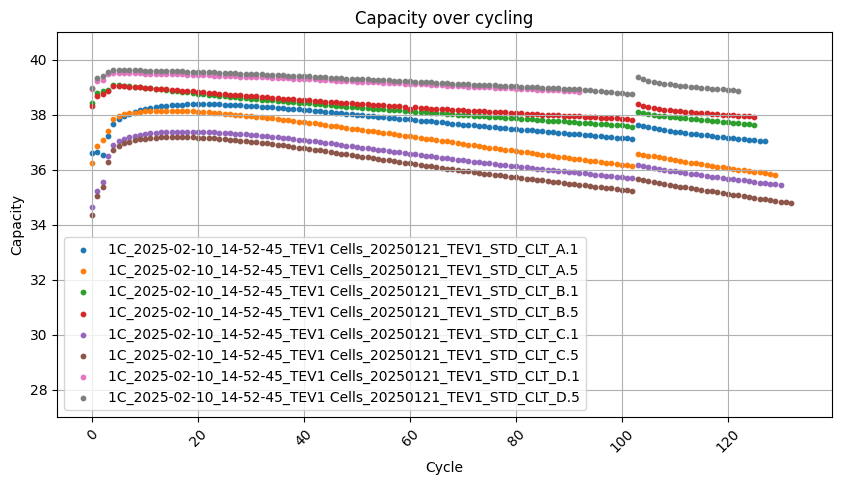

In [10]:
### For discharges data plotting
plt.figure(figsize=(10, 5))

# Go through all data saved in all_discharges and extract file name and discharges values
for file, discharges in all_discharges:

    # Definition of parameters for linear fitting analysis
    first_value = discharges[0] # Take the first value
    last_value = discharges[-1] # Take the last value
    # Extract x and y values
    x1, q1 = first_value 
    x2, q2 = last_value

    x, q = zip(*discharges)
    x = np.array(x).reshape(-1, 1)
    q = np.array(q)

    total_loss = q1 -q2

    # Calculation of linear fiiting function parameters (m * x + p)
    m = (q2 - q1) / (x2 - x1) #slop rate
    p = q1 - m * x1           #Intercept at origin


    # Creation of polynomial fitting (can be used for capacity losses prediction)
    degree = 5
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x)

    #fitting of the model to data sample
    model = LinearRegression()
    model.fit(x_poly, q)

    q_pred = model.predict(x_poly)

    ##Formatting of the fonction to be displayed
    coefficients = model.coef_
    intercept = model.intercept_
    polynomial_function = np.poly1d(np.flip(coefficients))
    print(f'Polynomial fitting fonction:\n{polynomial_function}')
    
    #R² calculation to determine if fitting model used is relevent
    r_squared = r2_score(q, q_pred)

    steps, qmax_values = zip(*discharges)
    #print(qmax_values)

    plt.scatter(steps, qmax_values, label = Path(file).stem, s = 10)

    # Linear and polynomial fitting plot
    ##plt.plot(x, m * x + p, label = Path(file).stem) #Remove comment to draw linear fitting model on graph
    ##plt.plot(x, q_pred, color = 'purple', label = 'Polynomial fitting')

    print(f'\033[1mFile name: {Path(file).stem}\033[0m\n'
          f'First data point: [{x1}, {q1:.4f}] -'
          f'- Last data point: [{x2}, {q2:.4f}]\n'
          f'Total capacity lost over cycling: {total_loss:.4f}\n'
          f'\033[1mLinear fitting:\033[0m\n'
          f'Capacity fading rate: {m:.4f} x + {p:.4f}\n'
          f'\033[1mPolynomial fitting:\033[0m\n'
          f'R² score: {r_squared:.4f}\n\n')

plt.ylim(27, 41)
plt.xlabel('Cycle')   # x axis title
plt.ylabel('Capacity')   # y axis title
plt.title('Capacity over cycling')  # Graph title
plt.xticks(rotation=45)
plt.legend(fontsize = 10)                  

plt.savefig(f'{Output_path}/fig_Capacity fading_full_cell_1C.png', dpi=300)

plt.grid()
plt.show()

File name: 1C_2025-01-29_15-15-58_TEV1 Cells_20250121_TEV1_STD_CLT_A.1
First data point: [0, 0.2243] -- Last data point: [58, 36.7102]
Total capacity lost over cycling: -36.4859
Linear fitting:
Capacity fading rate: 0.6291 x + 0.2243


File name: 1C_2025-01-29_15-15-58_TEV1 Cells_20250121_TEV1_STD_CLT_A.5
First data point: [0, 17.7242] -- Last data point: [58, 36.1843]
Total capacity lost over cycling: -18.4601
Linear fitting:
Capacity fading rate: 0.3183 x + 17.7242


File name: 1C_2025-01-29_15-15-58_TEV1 Cells_20250121_TEV1_STD_CLT_B.1
First data point: [0, 15.0596] -- Last data point: [57, 37.0227]
Total capacity lost over cycling: -21.9631
Linear fitting:
Capacity fading rate: 0.3853 x + 15.0596


File name: 1C_2025-01-29_15-15-58_TEV1 Cells_20250121_TEV1_STD_CLT_B.5
First data point: [0, 15.0099] -- Last data point: [57, 37.1584]
Total capacity lost over cycling: -22.1485
Linear fitting:
Capacity fading rate: 0.3886 x + 15.0099


File name: 1C_2025-01-29_15-15-58_TEV1 Cells_20250

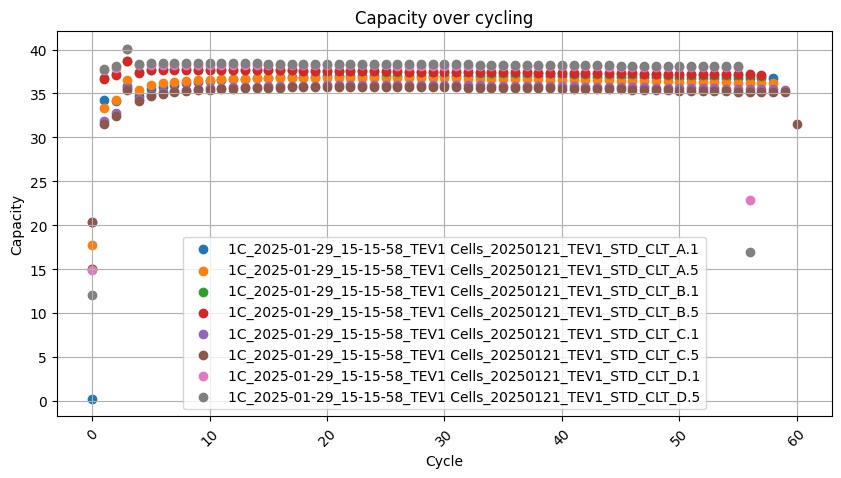

In [ ]:
### For charges data plotting
plt.figure(figsize=(10, 5))

for file, charges in all_charges:

    first_ch_value = charges[0]
    last_ch_value = charges[-1]

    ch_x1, ch_q1 = first_ch_value
    ch_x2, ch_q2 = last_ch_value

    total_ch_loss = ch_q1 - ch_q2

    a = (ch_q2 - ch_q1) / (ch_x2 - ch_x1) #slop rate
    b = ch_q1 - m * ch_x1           #Intercept at origin

    ch_steps, qcha_values = zip(*charges)
    #print(qmax_values)

    plt.scatter(ch_steps, qcha_values, label = Path(file).stem)

    print(f'\033[1mFile name: {Path(file).stem}\033[0m\n'
          f'First data point: [{ch_x1}, {ch_q1:.4f}] -'
          f'- Last data point: [{ch_x2}, {ch_q2:.4f}]\n'
          f'Total capacity lost over cycling: {total_ch_loss:.4f}\n'
          f'\033[1mLinear fitting:\033[0m\n'
          f'Capacity fading rate: {a:.4f} x + {b:.4f}\n\n')

plt.xlabel('Cycle')   # x axis title
plt.ylabel('Capacity')   # y axis title
plt.title('Capacity over cycling')  # Graph title
plt.xticks(rotation=45)
plt.legend()

plt.savefig(f'{Output_path}/fig_Capacity fading_full_cell_1C.png', dpi=300)

plt.grid()
plt.show()

In [ ]:
# prediction of capacity loss over cycling using linear fitting 
for file, discharges in all_discharges:

    x, q = zip(*discharges)
    x = np.array(x).reshape(-1, 1)
    q = np.array(q)

    ##Creation of polynomial fitting (can be used for capacity losses prediction)
    
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x)

    #fitting of the model to data sample
    model = LinearRegression()
    model.fit(x_poly, q)

    q_pred = model.predict(x_poly)

    #prediction for capacity fading based on fitting model
    new_x = np.array([[200]])  # New entry for prediction !!Must be higher than last cycle number!!
    new_x_poly = poly.transform(new_x)  # Format new entry
    predicted_q = model.predict(new_x_poly)  # Creation of model for prediction based on the linear fitting function 
    print(f'Prédiction pour x={new_x}: y={predicted_q[0]:.4f}')
    

Prédiction pour x=[[200]]: y=23.1981
Prédiction pour x=[[200]]: y=27.8411


In [ ]:
# More advanced model of prediction to estimated SoH < 80% threshold using linear fiiting
for file, discharges in all_discharges:

    first_value = discharges[0]
    last_value = discharges[-1]

    x1, q1 = first_value
    x2, q2 = last_value
    print(f'Initial retained capacity: {q1:.4f} Ah')

    SoH_80 = q1 * 0.8 # Define SoH threshold beased on inital capacity
    print(f'SoH threshold for 80%: {SoH_80:.4f} Ah')

    x, q = zip(*discharges)
    x = np.array(x).reshape(-1, 1)
    q = np.array(q)

    ##Creation of polynomial fitting (can be used for capacity losses prediction)
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x)

    #fitting of the model to data sample
    model = LinearRegression()
    model.fit(x_poly, q)

    q_pred = model.predict(x_poly)

    cycle = x[-1][0] +1
    predicted_q = None

    while predicted_q is None or predicted_q > SoH_80:

        new_x = np.array([[cycle]])
        new_x_poly = poly.transform(new_x)  # Format new entry
        predicted_q = model.predict(new_x_poly)

        predicted_q_value = predicted_q[0] if predicted_q.ndim > 0 else predicted_q

        if predicted_q <= SoH_80:
            print(f'SoH threshold reached for cycle n°{new_x[0][0]}: q={predicted_q_value:.4f}\n') # Print prediction if value reach 80% of SoH
            break # Stop while loop if condition reach

        cycle += 1 # increase cycle counter

Initial retained capacity: 39.8783 Ah
SoH threshold for 80%: 31.9027 Ah
SoH threshold reached for cycle n°179: q=31.7625

Initial retained capacity: 40.1996 Ah
SoH threshold for 80%: 32.1597 Ah
SoH threshold reached for cycle n°187: q=31.9660

